In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import time
import logging
import subprocess
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from collections.abc import Iterator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# For GPU array computation
import cupy as cp

# For GPU dataframe operation
import cudf

# For GPU Model
from cuml.ensemble    import RandomForestClassifier as RF

# Default DASK Libraries and set use GPU's
import dask
import dask_cudf
import dask.array as da
import dask.dataframe as dd
dask.config.set({"dataframe.backend": "cudf"})

# Set for Multi GPU use
from dask_cuda        import LocalCUDACluster
from dask.distributed import Client, wait, progress

# Dask Machine Learning Libraries
import dask_ml
from dask_ml.preprocessing   import StandardScaler
from dask_ml.metrics         import mean_squared_error 
from dask_ml.model_selection import train_test_split
from dask_ml.model_selection import GridSearchCV as GSCV

# For Train XGBoost
import xgboost as xgb

# For Visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import graphviz


In [2]:
cmd = "hostname --all-ip-addresses"
process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
IPADDR = str(output.decode()).split()[0]

cluster = LocalCUDACluster(ip=IPADDR, silence_logs=logging.ERROR)
client = Client(cluster)

In [3]:
class Timer:
    def __init__(self, name="cpu"):
        self.name = name
        
    def __enter__(self):
        self.start = time.perf_counter()
        
    def __exit__(self, type, value, trackback):
        self.end = time.perf_counter()
        self.execute_time = self.end - self.start
        print(f"{self.name} execute time : {self.execute_time:.4f} seconds")

In [4]:
train_path = "/media/HDD2/Data/AS_Dataset/train.csv"
test_path  = "/media/HDD2/Data/AS_Dataset/test.csv"

In [5]:
with Timer("DASK"):
    train_df = dd.read_csv(train_path)
    test_df  = dd.read_csv(test_path)

DASK execute time : 0.0627 seconds


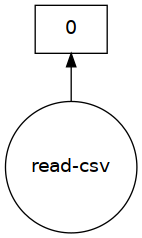

In [6]:
train_df.visualize()

In [7]:
with Timer("DASK"):
    train_df = dd.read_csv(train_path)
    test_df  = dd.read_csv(test_path)

DASK execute time : 0.0279 seconds


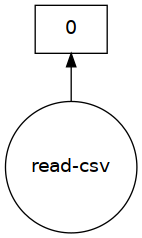

In [8]:
train_df.visualize()

In [9]:
def LabelEncoder(ddf:dd.DataFrame)->dd.DataFrame:
    columns = ddf.columns
    for c in columns:
        categories = ddf[c].compute().unique()
        cat2i   = {c : i for i, c in enumerate(categories.values_host)}
        i2cat   = {i : c for c, i in cat2i.items()}
        ddf[c] = ddf[c].map(cat2i)
    return ddf, i2cat

def LabelDecoder(ddf:dd.DataFrame, i2cat:dict) -> dd.DataFrame:
    ddf["Target"] = ddf["Target"].map(i2cat)
    return ddf

def StandardScaler(ddf:dd.DataFrame) -> dd.DataFrame:
    columns = ddf.columns
    for c in columns:
        mean = ddf[c].mean()
        std  = ddf[c].std()
        ddf[c]   = (ddf[c] - mean) / std
    return ddf

In [10]:
with Timer("DASK"):
    train_df.dropna()
    y_train, i2cat = LabelEncoder(train_df[["Target"]])
    X_train        = train_df.drop(columns=["Target", "id"])
    X_train        = StandardScaler(X_train)
    X_test         = test_df.drop(columns=["id"])
    
X_train = X_train.persist()
X_test  = X_test.persist()
y_train = y_train["Target"].persist()


DASK execute time : 1.5619 seconds


In [11]:
X_train = X_train.persist()
y_train = y_train.persist()
X_test  = X_test.persist()

In [18]:
params = {
    'verbosity': 2,
    'n_estimator' : 200,
    'objective': 'multi:softmax',
    'num_class': 3,
    'grow_policy': 'lossguide',
    'learning_rate': 0.001,
    'max_leaves': 64,
    'max_depth': 6,
    'eval_metric': 'auc',
    'tree_method': 'gpu_hist',
    'min_child_weight': 7,
    'colsample_bytree': 0.5,
    'reg_lambda': 0.5,
    'reg_alpha': 1
}

model = xgb.dask.DaskXGBClassifier(**params)
model.client = client
model.fit(X_train, y_train)

[14:16:32] task [xgboost.dask-1]:tcp://192.168.0.69:34837 got new rank 0
[14:16:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1701495763888/work/src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.



DaskXGBClassifier(colsample_bytree=0.5, eval_metric='auc',
                  grow_policy='lossguide', learning_rate=0.001, max_depth=6,
                  max_leaves=64, min_child_weight=7, n_estimator=200,
                  num_class=3, objective='multi:softprob', reg_alpha=1,
                  reg_lambda=0.5, tree_method='gpu_hist', verbosity=2)

In [26]:
train_out = model.predict(X_train)

In [23]:
prediction = model.predict(X_test)

In [24]:
with Timer("DASK"):
    out_dd = test_df[["id"]]  
    out_dd["Target"] = prediction
    out_dd = LabelDecoder(out_dd, i2cat)
    out_dd.compute().to_csv("./submission.csv", index=False)

DASK execute time : 0.3970 seconds
